In [1]:
# Import necessary libraries for pre-augmentation
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imgaug.augmenters as iaa
import shutil

# Define paths
data_dir = '/kaggle/input/shark-species/sharks'  # Original dataset
class_names = ['basking', 'sand tiger', 'whale', 'blue', 'white', 'tiger', 'whitetip', 'mako', 
               'blacktip', 'nurse', 'lemon', 'bull', 'hammerhead', 'thresher']  # List of shark species

# Define parameters for oversampling
target_count = 250  # Target 1000 images per class

# Create a new directory to store augmented images
augmented_dir = '/kaggle/working/augmented_shark_dataset_250'
os.makedirs(augmented_dir, exist_ok=True)

# Define a comprehensive augmentation sequence
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontally flip 50% of the images
    iaa.Flipud(0.3),  # Vertically flip 30% of the images
    iaa.Affine(
        rotate=(-30, 30),  # Rotate by -30 to 30 degrees
        scale=(0.8, 1.2),  # Scale images to 80%-120%
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # Translate by -20% to 20%
        shear=(-10, 10)  # Shear by -10 to 10 degrees
    ),
    iaa.GaussianBlur(sigma=(0, 1.5)),  # Apply Gaussian blur with sigma between 0 and 1.5
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Add Gaussian noise
    iaa.Sometimes(0.5, iaa.ContrastNormalization((0.5, 1.5))),  # Adjust contrast for 50% of images
    iaa.Sometimes(0.5, iaa.Multiply((0.8, 1.2))),  # Adjust brightness for 50% of images
])

# Iterate over each class
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    augmented_class_dir = os.path.join(augmented_dir, class_name)
    os.makedirs(augmented_class_dir, exist_ok=True)
    
    # Load images from the original class directory
    image_list = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if len(image_list) == 0:
        print(f"No valid image files found in {class_dir}")
        continue
    
    print(f"Class {class_name} has {len(image_list)} images before augmentation.")
    
    # Calculate oversampling factor to reach exactly 1000 images
    images_per_class = len(image_list)
    if images_per_class >= target_count:
        # If already more than 1000, randomly select 1000 images
        image_list = np.random.choice(image_list, target_count, replace=False).tolist()
    else:
        # Calculate how many augmented images are needed
        oversample_factor = int(np.ceil((target_count - images_per_class) / images_per_class))
    
    # Copy original images
    for image_name in image_list:
        img_path = os.path.join(class_dir, image_name)
        dest_path = os.path.join(augmented_class_dir, image_name)
        shutil.copy(img_path, dest_path)
    
    # Augment to reach 1000 images if needed
    if images_per_class < target_count:
        for image_name in image_list:
            img_path = os.path.join(class_dir, image_name)
            try:
                # Load image with PIL to handle RGBA conversion
                img_pil = Image.open(img_path)
                # Convert RGBA to RGB if necessary
                if img_pil.mode == 'RGBA':
                    img_pil = img_pil.convert('RGB')
                img = np.array(img_pil)
                
                # Ensure image has 3 channels (RGB)
                if len(img.shape) == 2 or img.shape[2] == 1:  # Grayscale to RGB
                    img = np.stack((img,) * 3, axis=-1) if len(img.shape) == 2 else np.repeat(img, 3, axis=2)
                
                # Apply augmentation sequence
                augmented_images = seq(images=[img] * oversample_factor)
                
                # Save augmented images
                for i, augmented_img in enumerate(augmented_images):
                    img_name = f"{os.path.splitext(image_name)[0]}_aug_{i}.jpg"
                    img_save_path = os.path.join(augmented_class_dir, img_name)
                    # Convert augmented image to PIL and ensure RGB mode
                    aug_img_pil = Image.fromarray(augmented_img)
                    if aug_img_pil.mode == 'RGBA':
                        aug_img_pil = aug_img_pil.convert('RGB')
                    aug_img_pil.save(img_save_path, 'JPEG')
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
                continue
    
    # Ensure exactly 1000 images by trimming if necessary
    final_images = [f for f in os.listdir(augmented_class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if len(final_images) > target_count:
        for img_name in final_images[target_count:]:
            os.remove(os.path.join(augmented_class_dir, img_name))
    print(f"Class {class_name} has {len(os.listdir(augmented_class_dir))} images after augmentation.")

print("Pre-augmentation to 250 images per class completed.")

/usr/local/lib/python3.10/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


Class basking has 93 images before augmentation.
Class basking has 250 images after augmentation.
Class sand tiger has 97 images before augmentation.
Class sand tiger has 250 images after augmentation.
Class whale has 132 images before augmentation.
Class whale has 250 images after augmentation.
Class blue has 107 images before augmentation.
Class blue has 250 images after augmentation.
Class white has 134 images before augmentation.
Class white has 250 images after augmentation.
Class tiger has 97 images before augmentation.
Class tiger has 250 images after augmentation.
Class whitetip has 125 images before augmentation.
Class whitetip has 250 images after augmentation.
Class mako has 101 images before augmentation.
Class mako has 250 images after augmentation.
Class blacktip has 114 images before augmentation.
Class blacktip has 250 images after augmentation.
Class nurse has 73 images before augmentation.
Class nurse has 250 images after augmentation.
Class lemon has 119 images befor

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Paths
augmented_dir = '/kaggle/working/augmented_shark_dataset_250'
train_dir = '/kaggle/working/augmented_shark_dataset_250/train'
val_dir = '/kaggle/working/augmented_shark_dataset_250/val'
test_dir = '/kaggle/working/augmented_shark_dataset_250/test'

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Split ratios
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Iterate over each class
for class_name in class_names:
    class_dir = os.path.join(augmented_dir, class_name)
    if not os.path.isdir(class_dir):
        print(f"Class directory {class_dir} not found, skipping.")
        continue
    
    # Get all images
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not images:
        print(f"No images found in {class_dir}")
        continue
    
    print(f"Class {class_name} has {len(images)} images.")
    
    # Split into train+val and test
    train_val_img, test_img = train_test_split(images, test_size=test_ratio, random_state=42)
    # Split train+val into train and val
    train_img, val_img = train_test_split(train_val_img, test_size=(val_ratio / (train_ratio + val_ratio)), random_state=42)
    
    # Copy images to respective directories
    for img in train_img:
        dest = os.path.join(train_dir, class_name, os.path.basename(img))
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        shutil.copy(img, dest)
    for img in val_img:
        dest = os.path.join(val_dir, class_name, os.path.basename(img))
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        shutil.copy(img, dest)
    for img in test_img:
        dest = os.path.join(test_dir, class_name, os.path.basename(img))
        os.makedirs(os.path.dirname(dest), exist_ok=True)
        shutil.copy(img, dest)

print("Dataset split completed (60/20/20 ratio).")

Class basking has 250 images.
Class sand tiger has 250 images.
Class whale has 250 images.
Class blue has 250 images.
Class white has 250 images.
Class tiger has 250 images.
Class whitetip has 250 images.
Class mako has 250 images.
Class blacktip has 250 images.
Class nurse has 250 images.
Class lemon has 250 images.
Class bull has 250 images.
Class hammerhead has 250 images.
Class thresher has 250 images.
Dataset split completed (60/20/20 ratio).


Using device: cuda
Loading datasets...


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train dataset: 2100 images, label range: 0 to 13
train class distribution: [150 150 150 150 150 150 150 150 150 150 150 150 150 150]
val dataset: 700 images, label range: 0 to 13
val class distribution: [50 50 50 50 50 50 50 50 50 50 50 50 50 50]
test dataset: 700 images, label range: 0 to 13
test class distribution: [50 50 50 50 50 50 50 50 50 50 50 50 50 50]
Number of classes: 14
Class names: ['basking', 'blacktip', 'blue', 'bull', 'hammerhead', 'lemon', 'mako', 'nurse', 'sand tiger', 'thresher', 'tiger', 'whale', 'white', 'whitetip']


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

<ipython-input-3-45dd3aa5ac70>:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_amp else None


Using Automatic Mixed Precision: True
Starting training for 50 epochs...


Epoch 1/50 [Train]:   0%|          | 0/33 [00:00<?, ?it/s]<ipython-input-3-45dd3aa5ac70>:193: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Valid]:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-3-45dd3aa5ac70>:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/50 [Valid]: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s, loss=2.8843, acc=0.0333]


Epoch 1/50 summary: Train Loss: 2.9361, Train Acc: 0.0876, Val Loss: 2.7899, Val Acc: 0.0729


Epoch 2/50 [Valid]: 100%|██████████| 11/11 [00:09<00:00,  1.16it/s, loss=2.1418, acc=0.5000]


Epoch 2/50 summary: Train Loss: 2.4939, Train Acc: 0.2152, Val Loss: 2.0075, Val Acc: 0.5057


Epoch 3/50 [Valid]: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s, loss=1.1238, acc=0.8833]


Epoch 3/50 summary: Train Loss: 1.8144, Train Acc: 0.5210, Val Loss: 1.3895, Val Acc: 0.7514


Epoch 4/50 [Valid]: 100%|██████████| 11/11 [00:09<00:00,  1.15it/s, loss=1.2046, acc=0.8667]


Epoch 4/50 summary: Train Loss: 1.4409, Train Acc: 0.7100, Val Loss: 1.1735, Val Acc: 0.8586


Epoch 5/50 [Valid]: 100%|██████████| 11/11 [00:09<00:00,  1.14it/s, loss=1.0037, acc=0.9500]


Epoch 5/50 summary: Train Loss: 1.2519, Train Acc: 0.8105, Val Loss: 1.0928, Val Acc: 0.8843


Epoch 6/50 [Valid]: 100%|██████████| 11/11 [00:09<00:00,  1.11it/s, loss=0.9537, acc=0.9333]


Epoch 6/50 summary: Train Loss: 1.1763, Train Acc: 0.8514, Val Loss: 1.0502, Val Acc: 0.9057


Epoch 7/50 [Valid]: 100%|██████████| 11/11 [00:09<00:00,  1.16it/s, loss=1.0237, acc=0.9000]


Epoch 7/50 summary: Train Loss: 1.1193, Train Acc: 0.8729, Val Loss: 1.0213, Val Acc: 0.9171


Epoch 8/50 [Valid]: 100%|██████████| 11/11 [00:09<00:00,  1.16it/s, loss=0.9065, acc=0.9667]


Epoch 8/50 summary: Train Loss: 1.0554, Train Acc: 0.9052, Val Loss: 1.0216, Val Acc: 0.9157


Epoch 9/50 [Valid]: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s, loss=0.8895, acc=0.9833]


Epoch 9/50 summary: Train Loss: 1.0213, Train Acc: 0.9143, Val Loss: 0.9889, Val Acc: 0.9257


Epoch 10/50 [Valid]: 100%|██████████| 11/11 [00:09<00:00,  1.16it/s, loss=0.8703, acc=0.9500]


Epoch 10/50 summary: Train Loss: 0.9832, Train Acc: 0.9333, Val Loss: 0.9577, Val Acc: 0.9357


Epoch 11/50 [Valid]: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s, loss=0.8472, acc=0.9833]


Epoch 11/50 summary: Train Loss: 0.9478, Train Acc: 0.9443, Val Loss: 0.9374, Val Acc: 0.9386


Epoch 12/50 [Valid]: 100%|██████████| 11/11 [00:09<00:00,  1.19it/s, loss=0.8897, acc=0.9500]


Epoch 12/50 summary: Train Loss: 0.9435, Train Acc: 0.9481, Val Loss: 0.9177, Val Acc: 0.9457


Epoch 13/50 [Valid]: 100%|██████████| 11/11 [00:09<00:00,  1.16it/s, loss=0.8578, acc=0.9833]


Epoch 13/50 summary: Train Loss: 0.9363, Train Acc: 0.9524, Val Loss: 0.8895, Val Acc: 0.9671


Epoch 14/50 [Valid]: 100%|██████████| 11/11 [00:09<00:00,  1.16it/s, loss=0.8407, acc=0.9833]


Epoch 14/50 summary: Train Loss: 0.9133, Train Acc: 0.9610, Val Loss: 0.9096, Val Acc: 0.9486


Epoch 15/50 [Valid]: 100%|██████████| 11/11 [00:09<00:00,  1.11it/s, loss=0.8118, acc=1.0000]


Epoch 15/50 summary: Train Loss: 0.9069, Train Acc: 0.9605, Val Loss: 0.9028, Val Acc: 0.9543


Epoch 16/50 [Valid]: 100%|██████████| 11/11 [00:09<00:00,  1.18it/s, loss=0.8266, acc=1.0000]


Epoch 16/50 summary: Train Loss: 0.9028, Train Acc: 0.9614, Val Loss: 0.9256, Val Acc: 0.9343


Epoch 17/50 [Valid]: 100%|██████████| 11/11 [00:09<00:00,  1.17it/s, loss=0.8324, acc=0.9833]


Epoch 17/50 summary: Train Loss: 0.9007, Train Acc: 0.9581, Val Loss: 0.8912, Val Acc: 0.9557


Epoch 18/50 [Valid]: 100%|██████████| 11/11 [00:09<00:00,  1.17it/s, loss=0.8040, acc=1.0000]


Epoch 18/50 summary: Train Loss: 0.8779, Train Acc: 0.9705, Val Loss: 0.8840, Val Acc: 0.9586


Epoch 19/50 [Valid]: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s, loss=0.8275, acc=0.9833]


Epoch 19/50 summary: Train Loss: 0.8678, Train Acc: 0.9724, Val Loss: 0.8614, Val Acc: 0.9714


Epoch 20/50 [Valid]: 100%|██████████| 11/11 [00:09<00:00,  1.17it/s, loss=0.8218, acc=0.9833]


Epoch 20/50 summary: Train Loss: 0.8618, Train Acc: 0.9719, Val Loss: 0.8721, Val Acc: 0.9614


Epoch 21/50 [Valid]: 100%|██████████| 11/11 [00:09<00:00,  1.13it/s, loss=0.7951, acc=1.0000]


Epoch 21/50 summary: Train Loss: 0.8490, Train Acc: 0.9781, Val Loss: 0.8935, Val Acc: 0.9500


Epoch 22/50 [Valid]: 100%|██████████| 11/11 [00:10<00:00,  1.10it/s, loss=0.8111, acc=1.0000]


Epoch 22/50 summary: Train Loss: 0.8519, Train Acc: 0.9748, Val Loss: 0.8647, Val Acc: 0.9614


Epoch 23/50 [Valid]: 100%|██████████| 11/11 [00:10<00:00,  1.10it/s, loss=0.8009, acc=1.0000]


Epoch 23/50 summary: Train Loss: 0.8422, Train Acc: 0.9800, Val Loss: 0.8563, Val Acc: 0.9671


Epoch 24/50 [Valid]: 100%|██████████| 11/11 [00:10<00:00,  1.06it/s, loss=0.8162, acc=0.9833]


Epoch 24/50 summary: Train Loss: 0.8411, Train Acc: 0.9790, Val Loss: 0.8669, Val Acc: 0.9586


Epoch 25/50 [Valid]: 100%|██████████| 11/11 [00:10<00:00,  1.02it/s, loss=0.7884, acc=1.0000]


Epoch 25/50 summary: Train Loss: 0.8303, Train Acc: 0.9843, Val Loss: 0.8579, Val Acc: 0.9586


Epoch 26/50 [Valid]: 100%|██████████| 11/11 [00:10<00:00,  1.08it/s, loss=0.8031, acc=0.9833]


Epoch 26/50 summary: Train Loss: 0.8430, Train Acc: 0.9786, Val Loss: 0.8692, Val Acc: 0.9571


Epoch 27/50 [Valid]: 100%|██████████| 11/11 [00:10<00:00,  1.02it/s, loss=0.7856, acc=1.0000]


Epoch 27/50 summary: Train Loss: 0.8417, Train Acc: 0.9805, Val Loss: 0.8475, Val Acc: 0.9714


Epoch 28/50 [Valid]: 100%|██████████| 11/11 [00:11<00:00,  1.02s/it, loss=0.7943, acc=1.0000]


Epoch 28/50 summary: Train Loss: 0.8302, Train Acc: 0.9833, Val Loss: 0.8440, Val Acc: 0.9714


Epoch 29/50 [Valid]: 100%|██████████| 11/11 [00:11<00:00,  1.01s/it, loss=0.7852, acc=1.0000]


Epoch 29/50 summary: Train Loss: 0.8223, Train Acc: 0.9867, Val Loss: 0.8461, Val Acc: 0.9657


Epoch 30/50 [Valid]: 100%|██████████| 11/11 [00:11<00:00,  1.04s/it, loss=0.7837, acc=1.0000]


Epoch 30/50 summary: Train Loss: 0.8216, Train Acc: 0.9848, Val Loss: 0.8405, Val Acc: 0.9729


Epoch 31/50 [Valid]: 100%|██████████| 11/11 [00:11<00:00,  1.00s/it, loss=0.7766, acc=1.0000]


Epoch 31/50 summary: Train Loss: 0.8202, Train Acc: 0.9852, Val Loss: 0.8441, Val Acc: 0.9657


Epoch 32/50 [Valid]: 100%|██████████| 11/11 [00:10<00:00,  1.03it/s, loss=0.7801, acc=1.0000]


Epoch 32/50 summary: Train Loss: 0.8163, Train Acc: 0.9876, Val Loss: 0.8362, Val Acc: 0.9729


Epoch 33/50 [Valid]: 100%|██████████| 11/11 [00:10<00:00,  1.03it/s, loss=0.7811, acc=1.0000]


Epoch 33/50 summary: Train Loss: 0.8176, Train Acc: 0.9848, Val Loss: 0.8352, Val Acc: 0.9729


Epoch 34/50 [Valid]: 100%|██████████| 11/11 [00:10<00:00,  1.03it/s, loss=0.7923, acc=1.0000]


Epoch 34/50 summary: Train Loss: 0.8147, Train Acc: 0.9857, Val Loss: 0.8293, Val Acc: 0.9743


Epoch 35/50 [Valid]: 100%|██████████| 11/11 [00:10<00:00,  1.02it/s, loss=0.7800, acc=1.0000]


Epoch 35/50 summary: Train Loss: 0.8081, Train Acc: 0.9871, Val Loss: 0.8260, Val Acc: 0.9757


Epoch 36/50 [Valid]: 100%|██████████| 11/11 [00:10<00:00,  1.02it/s, loss=0.7739, acc=1.0000]


Epoch 36/50 summary: Train Loss: 0.8036, Train Acc: 0.9938, Val Loss: 0.8203, Val Acc: 0.9814


Epoch 37/50 [Valid]: 100%|██████████| 11/11 [00:11<00:00,  1.02s/it, loss=0.7751, acc=1.0000]


Epoch 37/50 summary: Train Loss: 0.8048, Train Acc: 0.9914, Val Loss: 0.8218, Val Acc: 0.9743


Epoch 38/50 [Valid]: 100%|██████████| 11/11 [00:11<00:00,  1.01s/it, loss=0.7716, acc=1.0000]


Epoch 38/50 summary: Train Loss: 0.8042, Train Acc: 0.9881, Val Loss: 0.8241, Val Acc: 0.9743


Epoch 39/50 [Valid]: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it, loss=0.7714, acc=1.0000]


Epoch 39/50 summary: Train Loss: 0.8069, Train Acc: 0.9857, Val Loss: 0.8239, Val Acc: 0.9771


Epoch 40/50 [Valid]: 100%|██████████| 11/11 [00:10<00:00,  1.03it/s, loss=0.7844, acc=0.9833]


Epoch 40/50 summary: Train Loss: 0.7987, Train Acc: 0.9933, Val Loss: 0.8209, Val Acc: 0.9771


Epoch 41/50 [Valid]: 100%|██████████| 11/11 [00:11<00:00,  1.01s/it, loss=0.7754, acc=1.0000]


Epoch 41/50 summary: Train Loss: 0.8009, Train Acc: 0.9890, Val Loss: 0.8191, Val Acc: 0.9771


Epoch 42/50 [Valid]: 100%|██████████| 11/11 [00:10<00:00,  1.03it/s, loss=0.7762, acc=1.0000]


Epoch 42/50 summary: Train Loss: 0.7994, Train Acc: 0.9910, Val Loss: 0.8185, Val Acc: 0.9800


Epoch 43/50 [Valid]: 100%|██████████| 11/11 [00:10<00:00,  1.05it/s, loss=0.7740, acc=1.0000]


Epoch 43/50 summary: Train Loss: 0.7939, Train Acc: 0.9933, Val Loss: 0.8153, Val Acc: 0.9800


Epoch 44/50 [Valid]: 100%|██████████| 11/11 [00:10<00:00,  1.05it/s, loss=0.7743, acc=1.0000]


Epoch 44/50 summary: Train Loss: 0.7929, Train Acc: 0.9933, Val Loss: 0.8165, Val Acc: 0.9800


Epoch 45/50 [Valid]: 100%|██████████| 11/11 [00:10<00:00,  1.03it/s, loss=0.7733, acc=1.0000]


Epoch 45/50 summary: Train Loss: 0.8005, Train Acc: 0.9905, Val Loss: 0.8194, Val Acc: 0.9771


Epoch 46/50 [Valid]: 100%|██████████| 11/11 [00:10<00:00,  1.03it/s, loss=0.7731, acc=1.0000]


Epoch 46/50 summary: Train Loss: 0.7965, Train Acc: 0.9929, Val Loss: 0.8177, Val Acc: 0.9800


Epoch 47/50 [Valid]: 100%|██████████| 11/11 [00:10<00:00,  1.02it/s, loss=0.7756, acc=1.0000]


Epoch 47/50 summary: Train Loss: 0.7943, Train Acc: 0.9933, Val Loss: 0.8165, Val Acc: 0.9786


Epoch 48/50 [Valid]: 100%|██████████| 11/11 [00:11<00:00,  1.03s/it, loss=0.7748, acc=1.0000]


Epoch 48/50 summary: Train Loss: 0.7950, Train Acc: 0.9938, Val Loss: 0.8174, Val Acc: 0.9800


Epoch 49/50 [Valid]: 100%|██████████| 11/11 [00:10<00:00,  1.06it/s, loss=0.7741, acc=1.0000]


Epoch 49/50 summary: Train Loss: 0.7992, Train Acc: 0.9914, Val Loss: 0.8163, Val Acc: 0.9800


Epoch 50/50 [Valid]: 100%|██████████| 11/11 [00:10<00:00,  1.01it/s, loss=0.7749, acc=1.0000]


Epoch 50/50 summary: Train Loss: 0.7972, Train Acc: 0.9929, Val Loss: 0.8161, Val Acc: 0.9800
Training completed. Final model saved.
Evaluating on test set...


Testing:   0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-3-45dd3aa5ac70>:310: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Testing: 100%|██████████| 11/11 [00:10<00:00,  1.06it/s, loss=0.9450, acc=0.9333]



Final Results:
Train Accuracy: 0.9929
Validation Accuracy: 0.9800
Test Accuracy: 0.9571

Per-Class Accuracy:
basking: 100.00%
blacktip: 98.00%
blue: 100.00%
bull: 86.00%
hammerhead: 98.00%
lemon: 88.00%
mako: 98.00%
nurse: 100.00%
sand tiger: 98.00%
thresher: 96.00%
tiger: 90.00%
whale: 100.00%
white: 96.00%
whitetip: 92.00%

Classification Report - Training Set:
              precision    recall  f1-score   support

     basking       0.99      1.00      1.00       170
    blacktip       1.00      0.99      1.00       150
        blue       1.00      0.99      1.00       161
        bull       0.98      0.98      0.98       155
  hammerhead       0.99      0.99      0.99       156
       lemon       0.98      0.99      0.99       144
        mako       1.00      0.98      0.99       148
       nurse       1.00      1.00      1.00       148
  sand tiger       0.99      1.00      1.00       143
    thresher       0.99      1.00      1.00       124
       tiger       1.00      0.99     

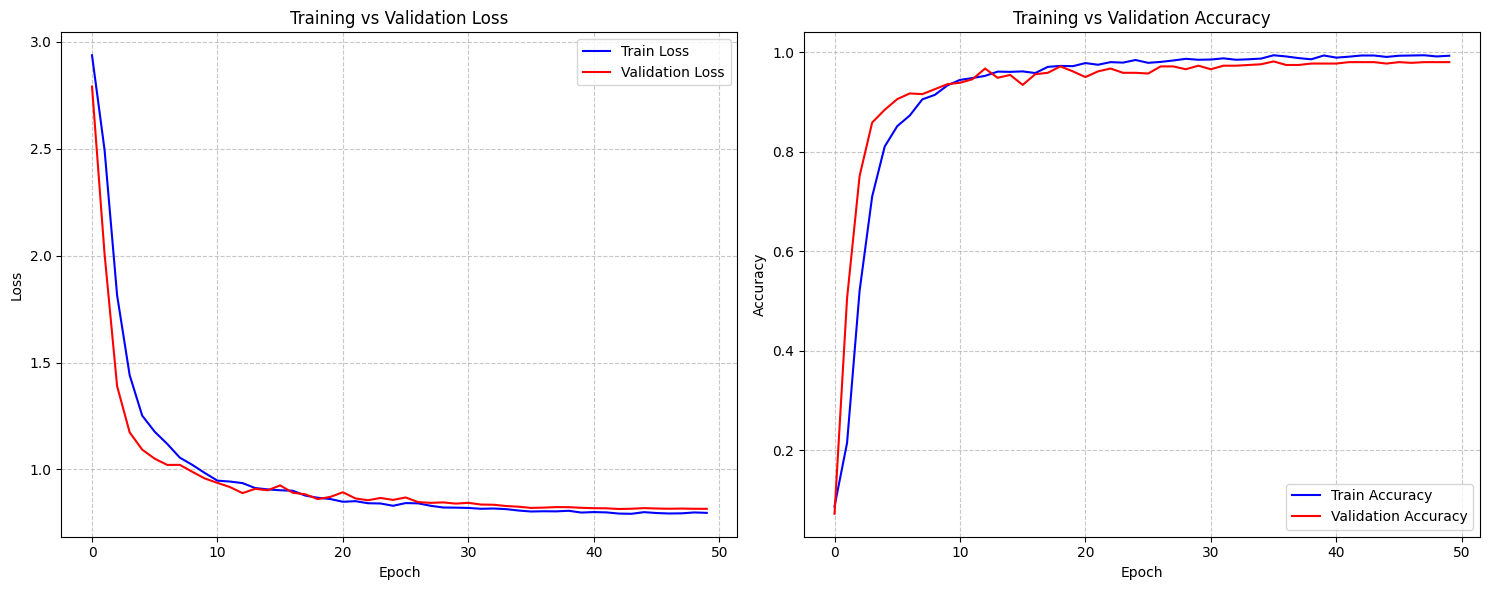

Plotting confusion matrices...


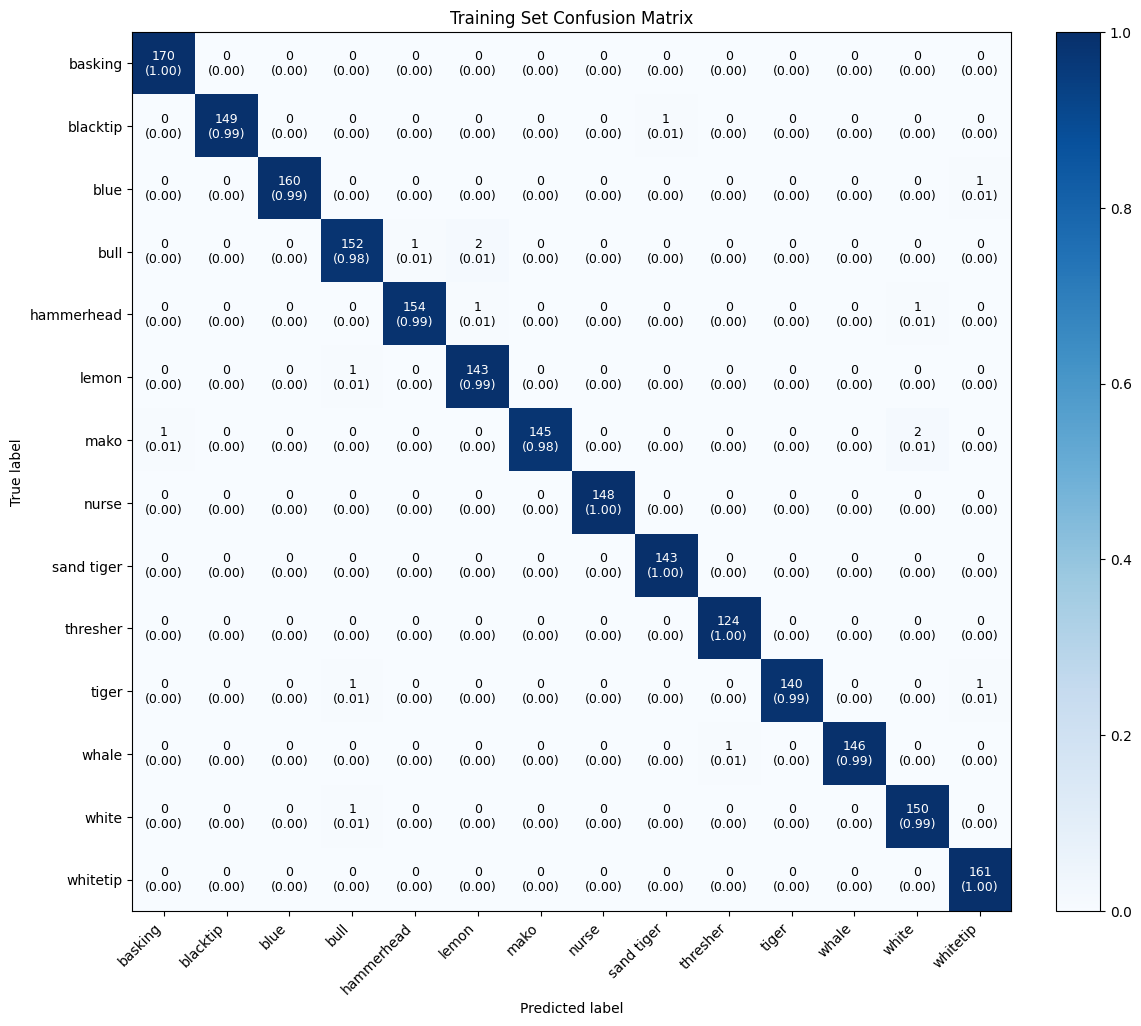

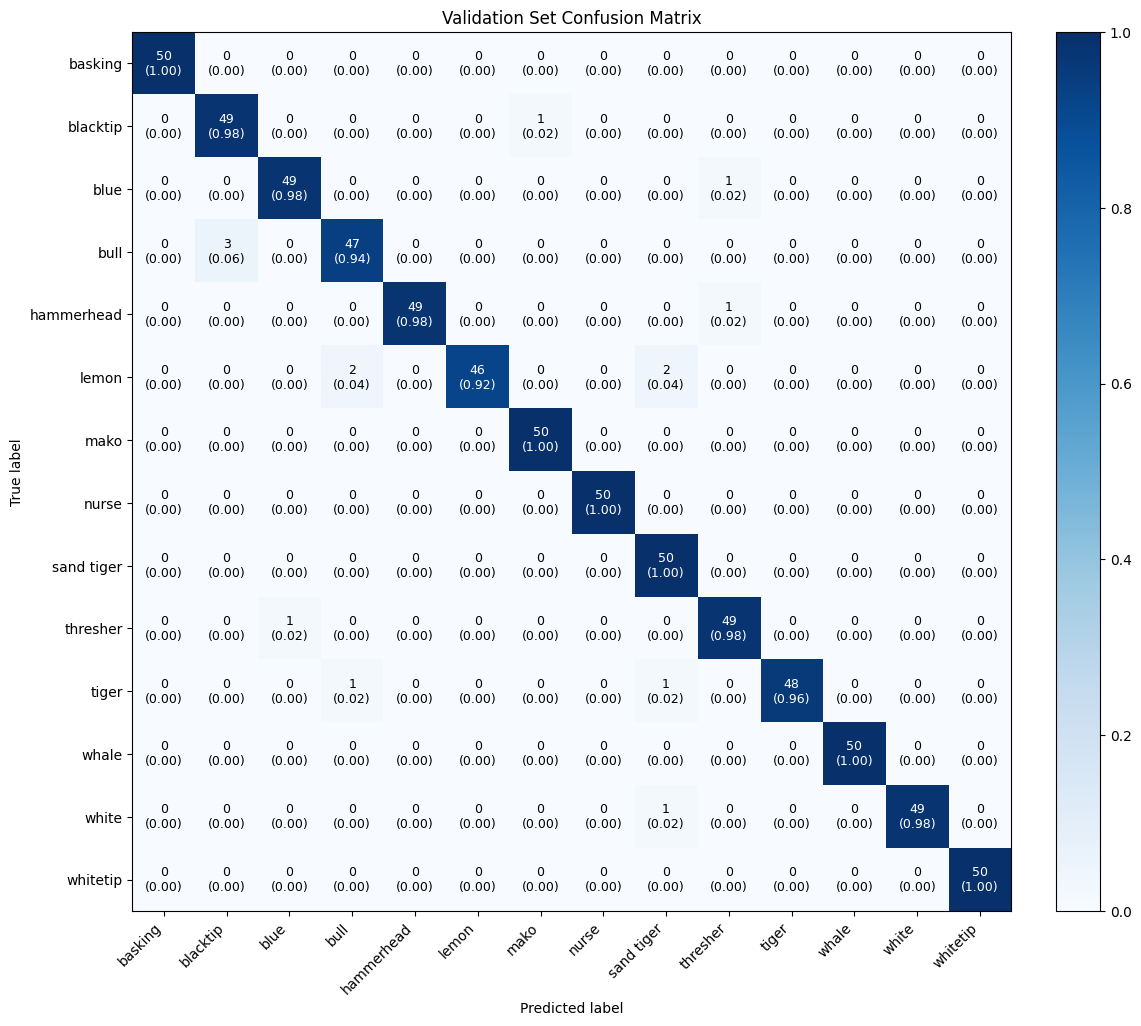

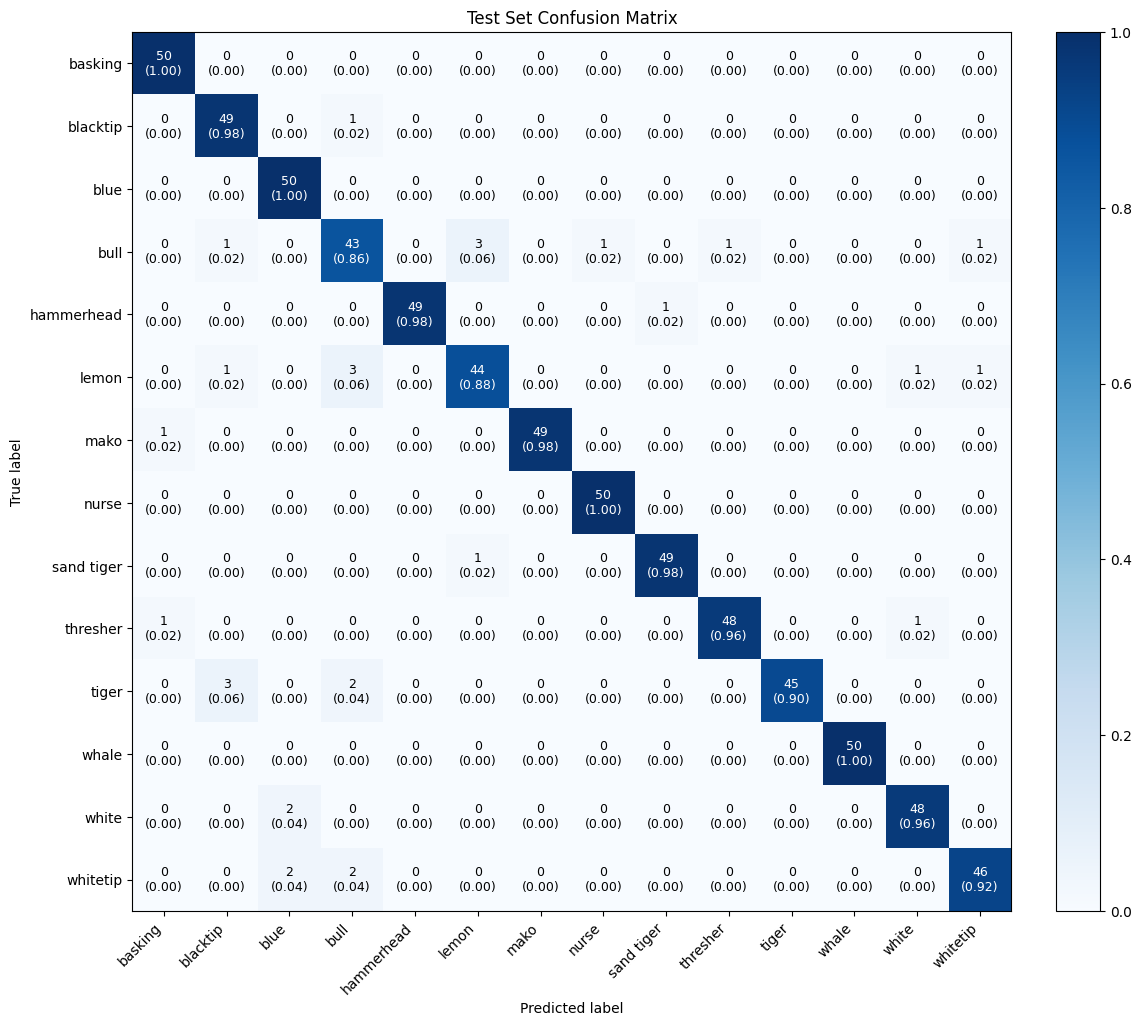

Evaluation complete. All visualizations saved to the working directory.


In [3]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
from timm import create_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from timm.scheduler import CosineLRScheduler
from timm.loss import LabelSmoothingCrossEntropy
import os
from tqdm import tqdm

# Set up GPU usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Enable cuDNN benchmarking for faster training
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

# Define transformations with advanced augmentation during training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
    transforms.RandomGrayscale(p=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2)
])

# Define test-specific transformations without augmentation
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Specify dataset directories
train_dir = '/kaggle/working/augmented_shark_dataset_250/train'
val_dir = '/kaggle/working/augmented_shark_dataset_250/val'
test_dir = '/kaggle/working/augmented_shark_dataset_250/test'

# Set up pin memory for faster data transfer to GPU
pin_memory = device.type == 'cuda'

# Load datasets
print("Loading datasets...")
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Debug: Check label range in datasets
for dataset, name in [(train_dataset, 'train'), (val_dataset, 'val'), (test_dataset, 'test')]:
    labels = [label for _, label in dataset]
    if labels:
        max_label = max(labels)
        min_label = min(labels)
        print(f"{name} dataset: {len(dataset)} images, label range: {min_label} to {max_label}")
        print(f"{name} class distribution: {np.bincount([label for _, label in dataset])}")

# Compute class weights to address class imbalance
class_counts = np.bincount([label for _, label in train_dataset])
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_weights)  # Normalize
sample_weights = [class_weights[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(sample_weights, len(train_dataset), replacement=True)

# Set optimal batch size based on GPU memory (adjust if needed)
batch_size = 64
num_workers = 4  # Adjust based on CPU cores

# Configure data loaders with optimized settings
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    sampler=sampler, 
    num_workers=num_workers, 
    pin_memory=pin_memory,
    persistent_workers=True if num_workers > 0 else False
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=pin_memory,
    persistent_workers=True if num_workers > 0 else False
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=num_workers, 
    pin_memory=pin_memory,
    persistent_workers=True if num_workers > 0 else False
)

# Initialize the ViT model
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Class names: {train_dataset.classes}")

# Create ViT model with advanced settings
model = create_model(
    'vit_base_patch16_224', 
    pretrained=True, 
    num_classes=num_classes, 
    drop_rate=0.1,  # Dropout rate
    attn_drop_rate=0.05,  # Attention dropout
    drop_path_rate=0.1  # Stochastic depth
)
model = model.to(device)

# Check for mixed precision support
use_amp = True if device.type == 'cuda' else False
scaler = torch.cuda.amp.GradScaler() if use_amp else None
print(f"Using Automatic Mixed Precision: {use_amp}")

# Set up optimizer with learning rate depending on batch size
base_lr = 1e-4
optimizer = optim.AdamW(
    model.parameters(), 
    lr=base_lr, 
    weight_decay=0.05,
    betas=(0.9, 0.999),
    eps=1e-8
)

# Label smoothing for robust learning
criterion = LabelSmoothingCrossEntropy(smoothing=0.15)

# Learning rate scheduler with cosine annealing
num_epochs = 50
warmup_epochs = 5

scheduler = CosineLRScheduler(
    optimizer,
    t_initial=num_epochs,
    lr_min=1e-6,
    warmup_t=warmup_epochs,
    warmup_lr_init=1e-7,
    cycle_limit=1
)

# Initialize lists to store performance metrics
train_losses, val_losses, train_accs, val_accs = [], [], [], []

# Create directory for checkpoints
os.makedirs('/kaggle/working/checkpoints', exist_ok=True)

# Function to save model checkpoint
def save_checkpoint(model, epoch, filename):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None
    }
    torch.save(state, filename)

# Training loop with progress bars and optimized GPU usage
print(f"Starting training for {num_epochs} epochs...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    y_true_train = []
    y_pred_train = []
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        # Clear gradients
        optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
        
        # Forward pass with mixed precision
        if use_amp:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            # Backward pass with scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # Update metrics
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data).item()
        
        # Store predictions for confusion matrix
        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(preds.cpu().numpy())
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{torch.sum(preds == labels.data).item() / len(labels):.4f}"
        })
    
    # Compute epoch metrics
    train_loss = train_loss / len(train_dataset)
    train_acc = train_correct / len(train_dataset)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    y_true_val = []
    y_pred_val = []
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]")
        
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            # Forward pass with mixed precision
            if use_amp:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            # Update metrics
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data).item()
            
            # Store predictions for confusion matrix
            y_true_val.extend(labels.cpu().numpy())
            y_pred_val.extend(preds.cpu().numpy())
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'acc': f"{torch.sum(preds == labels.data).item() / len(labels):.4f}"
            })
    
    # Compute epoch metrics
    val_loss = val_loss / len(val_dataset)
    val_acc = val_correct / len(val_dataset)
    
    # Record metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    # Print epoch summary
    print(f"Epoch {epoch+1}/{num_epochs} summary: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        save_checkpoint(model, epoch, f'/kaggle/working/checkpoints/shark_vit_epoch{epoch+1}.pth')
    
    # Always save the latest model
    torch.save(model.state_dict(), '/kaggle/working/shark_vit_latest.pth')
    
    # Step the learning rate scheduler
    scheduler.step(epoch + 1)

# Save the final model
torch.save(model.state_dict(), '/kaggle/working/shark_vit_final.pth')
print("Training completed. Final model saved.")

# Test evaluation with the final model
print("Evaluating on test set...")
model.eval()
test_loss = 0.0
test_correct = 0
y_true_test = []
y_pred_test = []
class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="Testing")
    
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        # Forward pass with mixed precision
        if use_amp:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        # Update metrics
        test_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels.data).item()
        
        # Store predictions for confusion matrix
        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(preds.cpu().numpy())
        
        # Calculate per-class accuracy
        for i in range(len(labels)):
            label = labels[i].item()
            class_correct[label] += (preds[i] == label).item()
            class_total[label] += 1
            
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'acc': f"{torch.sum(preds == labels.data).item() / len(labels):.4f}"
        })

# Calculate test metrics
test_loss = test_loss / len(test_dataset)
test_acc = test_correct / len(test_dataset)

# Calculate per-class accuracy
class_accuracy = [100 * correct / max(1, total) for correct, total in zip(class_correct, class_total)]

# Print accuracies for all sets
print(f"\nFinal Results:")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Print per-class accuracy
print("\nPer-Class Accuracy:")
for i, (accuracy, class_name) in enumerate(zip(class_accuracy, test_dataset.classes)):
    print(f"{class_name}: {accuracy:.2f}%")

# Define function to plot training vs validation metrics
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, 'b-', label='Train Loss')
    plt.plot(val_losses, 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, 'b-', label='Train Accuracy')
    plt.plot(val_accs, 'r-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/training_metrics.png')
    plt.show()

# Define function to plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 10))
    
    # Plot the confusion matrix
    ax = plt.subplot(111)
    im = ax.imshow(cm_norm, interpolation='nearest', cmap='Blues')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    
    # Set labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    fmt = '.2f'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text_color = 'white' if cm_norm[i, j] > 0.5 else 'black'
            plt.text(j, i, f"{cm[i, j]}\n({cm_norm[i, j]:.2f})", 
                    ha="center", va="center", color=text_color,
                    fontsize=9)
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.savefig(f'/kaggle/working/{title.lower().replace(" ", "_")}.png')
    plt.show()

# Print classification report for all sets
print("\nClassification Report - Training Set:")
print(classification_report(y_true_train, y_pred_train, target_names=train_dataset.classes))

print("\nClassification Report - Validation Set:")
print(classification_report(y_true_val, y_pred_val, target_names=val_dataset.classes))

print("\nClassification Report - Test Set:")
print(classification_report(y_true_test, y_pred_test, target_names=test_dataset.classes))

# Display training vs validation results
print("Plotting metrics...")
plot_metrics(train_losses, val_losses, train_accs, val_accs)

# Plot confusion matrices
print("Plotting confusion matrices...")
plot_confusion_matrix(y_true_train, y_pred_train, train_dataset.classes, title='Training Set Confusion Matrix')
plot_confusion_matrix(y_true_val, y_pred_val, val_dataset.classes, title='Validation Set Confusion Matrix')
plot_confusion_matrix(y_true_test, y_pred_test, test_dataset.classes, title='Test Set Confusion Matrix')

print("Evaluation complete. All visualizations saved to the working directory.")